In [1]:
# Import libraries
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [2]:
# Import review csv's
df50=pd.read_csv('Reviews_5.0th_attempt.csv', index_col=0, dtype={'found_helpful':object})

df55=pd.read_csv('Reviews_5.5th_attempt.csv', index_col=0, dtype={'found_helpful':object})

df58=pd.read_csv('Reviews_5.8th_attempt.csv', index_col=0, dtype={'found_helpful':object})

df59=pd.read_csv('Reviews_5.9th_attempt.csv', index_col=0, dtype={'found_helpful':object})

# Concate data frames to make one to work with
df = pd.concat([df50,df55,df58,df59])
df.head()

id  page_number                   date  \
0  R2TNZOB11M7GTI            1         on May 7, 2018   
1  R1NKR6LYRKGSK5            1   on November 24, 2017   
2  R1Q0LAYRPC7DEQ            1  on September 13, 2017   
3   RF1ZFTOETEJMR            1    on January 24, 2018   
4  R184SCFAVQ5PD1            1    on January 14, 2018   

                                               title              rating  \
0           Great- Crunchyroll app needs help though  4.0 out of 5 stars   
1  Xbox One isn’t a bad option the problem is it’...  5.0 out of 5 stars   
2                Why did I wait so long to buy this?  5.0 out of 5 stars   
3            Great Product for Tech Troubled Seniors  5.0 out of 5 stars   
4              Fire TV Stick with Alexa Voice Remote  5.0 out of 5 stars   

   varified_purchase found_helpful  \
0                  1             3   
1                  1             2   
2                  1            16   
3                  1             4   
4                  1            32   

                                                body  \
0  Got it in June 2017. Doesn't work well if you ...   
1  Okay, I have the Echo Show a regular Echo and ...   
2  What took me so long to order a Fire TV Stick?...   
3  I bought this Fire TV Stick for my 85 year old...   
4  After customer service contacted me about the ...   

                                                 url  
0  https://www.amazon.com/All-New-Fire-TV-Stick-W...  
1  https://www.amazon.com/All-New-Fire-TV-Stick-W...  
2  https://www.amazon.com/All-New-Fire-TV-Stick-W...  
3  https://www.amazon.com/All-New-Fire-TV-Stick-W...  
4  https://www.amazon.com/All-New-Fire-TV-Stick-W...

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232350 entries, 0 to 12899
Data columns (total 9 columns):
id                   232350 non-null object
page_number          232350 non-null int64
date                 232350 non-null object
title                232344 non-null object
rating               232350 non-null object
varified_purchase    232350 non-null int64
found_helpful        232350 non-null object
body                 232306 non-null object
url                  232350 non-null object
dtypes: int64(2), object(7)
memory usage: 17.7+ MB


In [4]:
# Clean up data and convert to correct data types

# Get rid of duplicate reviews
df.drop_duplicates(['id'], inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)

# Slice date and convert to datetime data type
df['date']=pd.to_datetime(df['date'][3:], infer_datetime_format=True)

# Slice rating and convert to int
df['rating']=df['rating'].str.slice(stop=1).astype('int')

# Cleaning found_helpful and converting to int
df['found_helpful']=df['found_helpful'].str.replace(',','').astype('int')

# Setting url as category data type
df['url']=df['url'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185498 entries, 0 to 185497
Data columns (total 9 columns):
id                   185498 non-null object
page_number          185498 non-null int64
date                 185495 non-null datetime64[ns]
title                185492 non-null object
rating               185498 non-null int32
varified_purchase    185498 non-null int64
found_helpful        185498 non-null int32
body                 185470 non-null object
url                  185498 non-null category
dtypes: category(1), datetime64[ns](1), int32(2), int64(2), object(3)
memory usage: 10.4+ MB


In [5]:
# Get word count for each review
df['body_word_count']=df['body'].str.lower().str.split('[\W_]').str.len()

In [6]:
# Create new column with review title and review body concatenated together with the
# review title as the first sentence, and preps for setence tokenizing.

# Create empty list variable to store data from for loop in
all_text=[]

# For loop for evaluating whether or not the review has a title and body and whether 
# or not each title has end of sentence punctuation.This for loop assumes that each 
# review has a title or body or both, but that it not missing both.
for i in df.index:
    # If title is null append body alone to all_text
    if type(df['title'][i]) is float:
        all_text.append(df['body'][i])
        
    # If body is null append title alone to all_text
    elif type(df['body'][i]) is float:
        all_text.append(df['title'][i])
    
    # Checks title for end of sentence punctuation and adds a period if it does not.
    # Stores title and review together for each review.
    else:
        if df['title'][i][-1:] not in ['.','?','!']:
            all_text.append(df['title'][i]+'. '+df['body'][i])
        else:
            all_text.append(df['title'][i]+' '+df['body'][i])

# Creates new column in df from the output of the for loop
df['all_text']=all_text

In [7]:
# Creates word_tokens from all_text, converts to lower case, removes punctuation and
# tokenizes words.
df['word_tokens'] = df['all_text'].str.lower().str.replace(r'[^\w\s]', '').apply(word_tokenize)

In [8]:
# Creates stop_words list
stop_words = [word.replace("'", '') for word in stopwords.words('english')]

# Creates add_words list from words I found to be repetitive and not terribly meaningful
# throught the different ratings.
add_words = 'one two three four five star stars fire stick firestick amazon'.split()

# Adds add_words to stop_words
stop_words = stop_words+add_words

In [9]:
# Removes stop_words from word_tokens
df['word_tokens'] = df['word_tokens'].apply(lambda x: [i for i in x if i not in stop_words])

In [10]:
# Create data frames divided by rating
df1 = df[df['rating']==1]
df2 = df[df['rating']==2]
df3 = df[df['rating']==3]
df4 = df[df['rating']==4]
df5 = df[df['rating']==5]

In [11]:
df1.describe()

page_number   rating  varified_purchase  found_helpful  \
count  12166.000000  12166.0       12166.000000   12166.000000   
mean    1840.016932      1.0           0.956354       0.901118   
std     1280.093031      0.0           0.204315       6.418416   
min        1.000000      1.0           0.000000       0.000000   
25%      546.250000      1.0           1.000000       0.000000   
50%     1820.500000      1.0           1.000000       0.000000   
75%     3014.000000      1.0           1.000000       1.000000   
max     3773.000000      1.0           1.000000     578.000000   

       body_word_count  
count     12166.000000  
mean         46.498685  
std          62.742396  
min           1.000000  
25%          12.000000  
50%          28.000000  
75%          57.000000  
max        2112.000000

In [12]:
df2.describe()

page_number  rating  varified_purchase  found_helpful  body_word_count
count  6164.000000  6164.0        6164.000000    6164.000000      6163.000000
mean   1538.742700     2.0           0.967229       0.389033        51.747526
std    1168.056516     0.0           0.178051       2.036543        66.973612
min       1.000000     2.0           0.000000       0.000000         1.000000
25%     447.000000     2.0           1.000000       0.000000        14.000000
50%    1401.000000     2.0           1.000000       0.000000        32.000000
75%    2432.000000     2.0           1.000000       0.000000        63.000000
max    3773.000000     2.0           1.000000      70.000000      1030.000000

In [13]:
df3.describe()

page_number  rating  varified_purchase  found_helpful  body_word_count
count  9542.000000  9542.0        9542.000000    9542.000000      9541.000000
mean   1514.512157     3.0           0.977258       0.251415        45.569647
std    1108.860006     0.0           0.149086       2.527904        59.571549
min       2.000000     3.0           0.000000       0.000000         1.000000
25%     490.250000     3.0           1.000000       0.000000        13.000000
50%    1391.000000     3.0           1.000000       0.000000        28.000000
75%    2353.000000     3.0           1.000000       0.000000        55.000000
max    3773.000000     3.0           1.000000     189.000000      1331.000000

In [14]:
df4.describe()

page_number   rating  varified_purchase  found_helpful  \
count  22294.000000  22294.0       22294.000000   22294.000000   
mean    1752.999237      4.0           0.988427       0.081233   
std     1080.117405      0.0           0.106954       1.238954   
min        1.000000      4.0           0.000000       0.000000   
25%      789.250000      4.0           1.000000       0.000000   
50%     1725.000000      4.0           1.000000       0.000000   
75%     2682.000000      4.0           1.000000       0.000000   
max     3773.000000      4.0           1.000000     162.000000   

       body_word_count  
count     22291.000000  
mean         29.965412  
std          47.247832  
min           1.000000  
25%           7.000000  
50%          16.000000  
75%          35.000000  
max        1305.000000

In [15]:
df5.describe()

page_number    rating  varified_purchase  found_helpful  \
count  135332.000000  135332.0      135332.000000  135332.000000   
mean     1915.733522       5.0           0.988399       0.376430   
std      1037.463278       0.0           0.107082      90.763956   
min         1.000000       5.0           0.000000       0.000000   
25%      1025.000000       5.0           1.000000       0.000000   
50%      1933.000000       5.0           1.000000       0.000000   
75%      2822.000000       5.0           1.000000       0.000000   
max      3773.000000       5.0           1.000000   32620.000000   

       body_word_count  
count    135309.000000  
mean         18.437561  
std          30.640912  
min           1.000000  
25%           4.000000  
50%          10.000000  
75%          21.000000  
max        2057.000000

In [16]:
# Create counter object for df
word_count=Counter()
df['word_tokens'].apply(word_count.update)

# Create counter object for df1
word_count_1=Counter()
df1['word_tokens'].apply(word_count_1.update)

# Create counter object for df2
word_count_2=Counter()
df2['word_tokens'].apply(word_count_2.update)

# Create counter object for df3
word_count_3=Counter()
df3['word_tokens'].apply(word_count_3.update)

# Create counter object for df4
word_count_4=Counter()
df4['word_tokens'].apply(word_count_4.update)

# Create counter object for df5
word_count_5=Counter()
df5['word_tokens'].apply(word_count_5.update)

print()

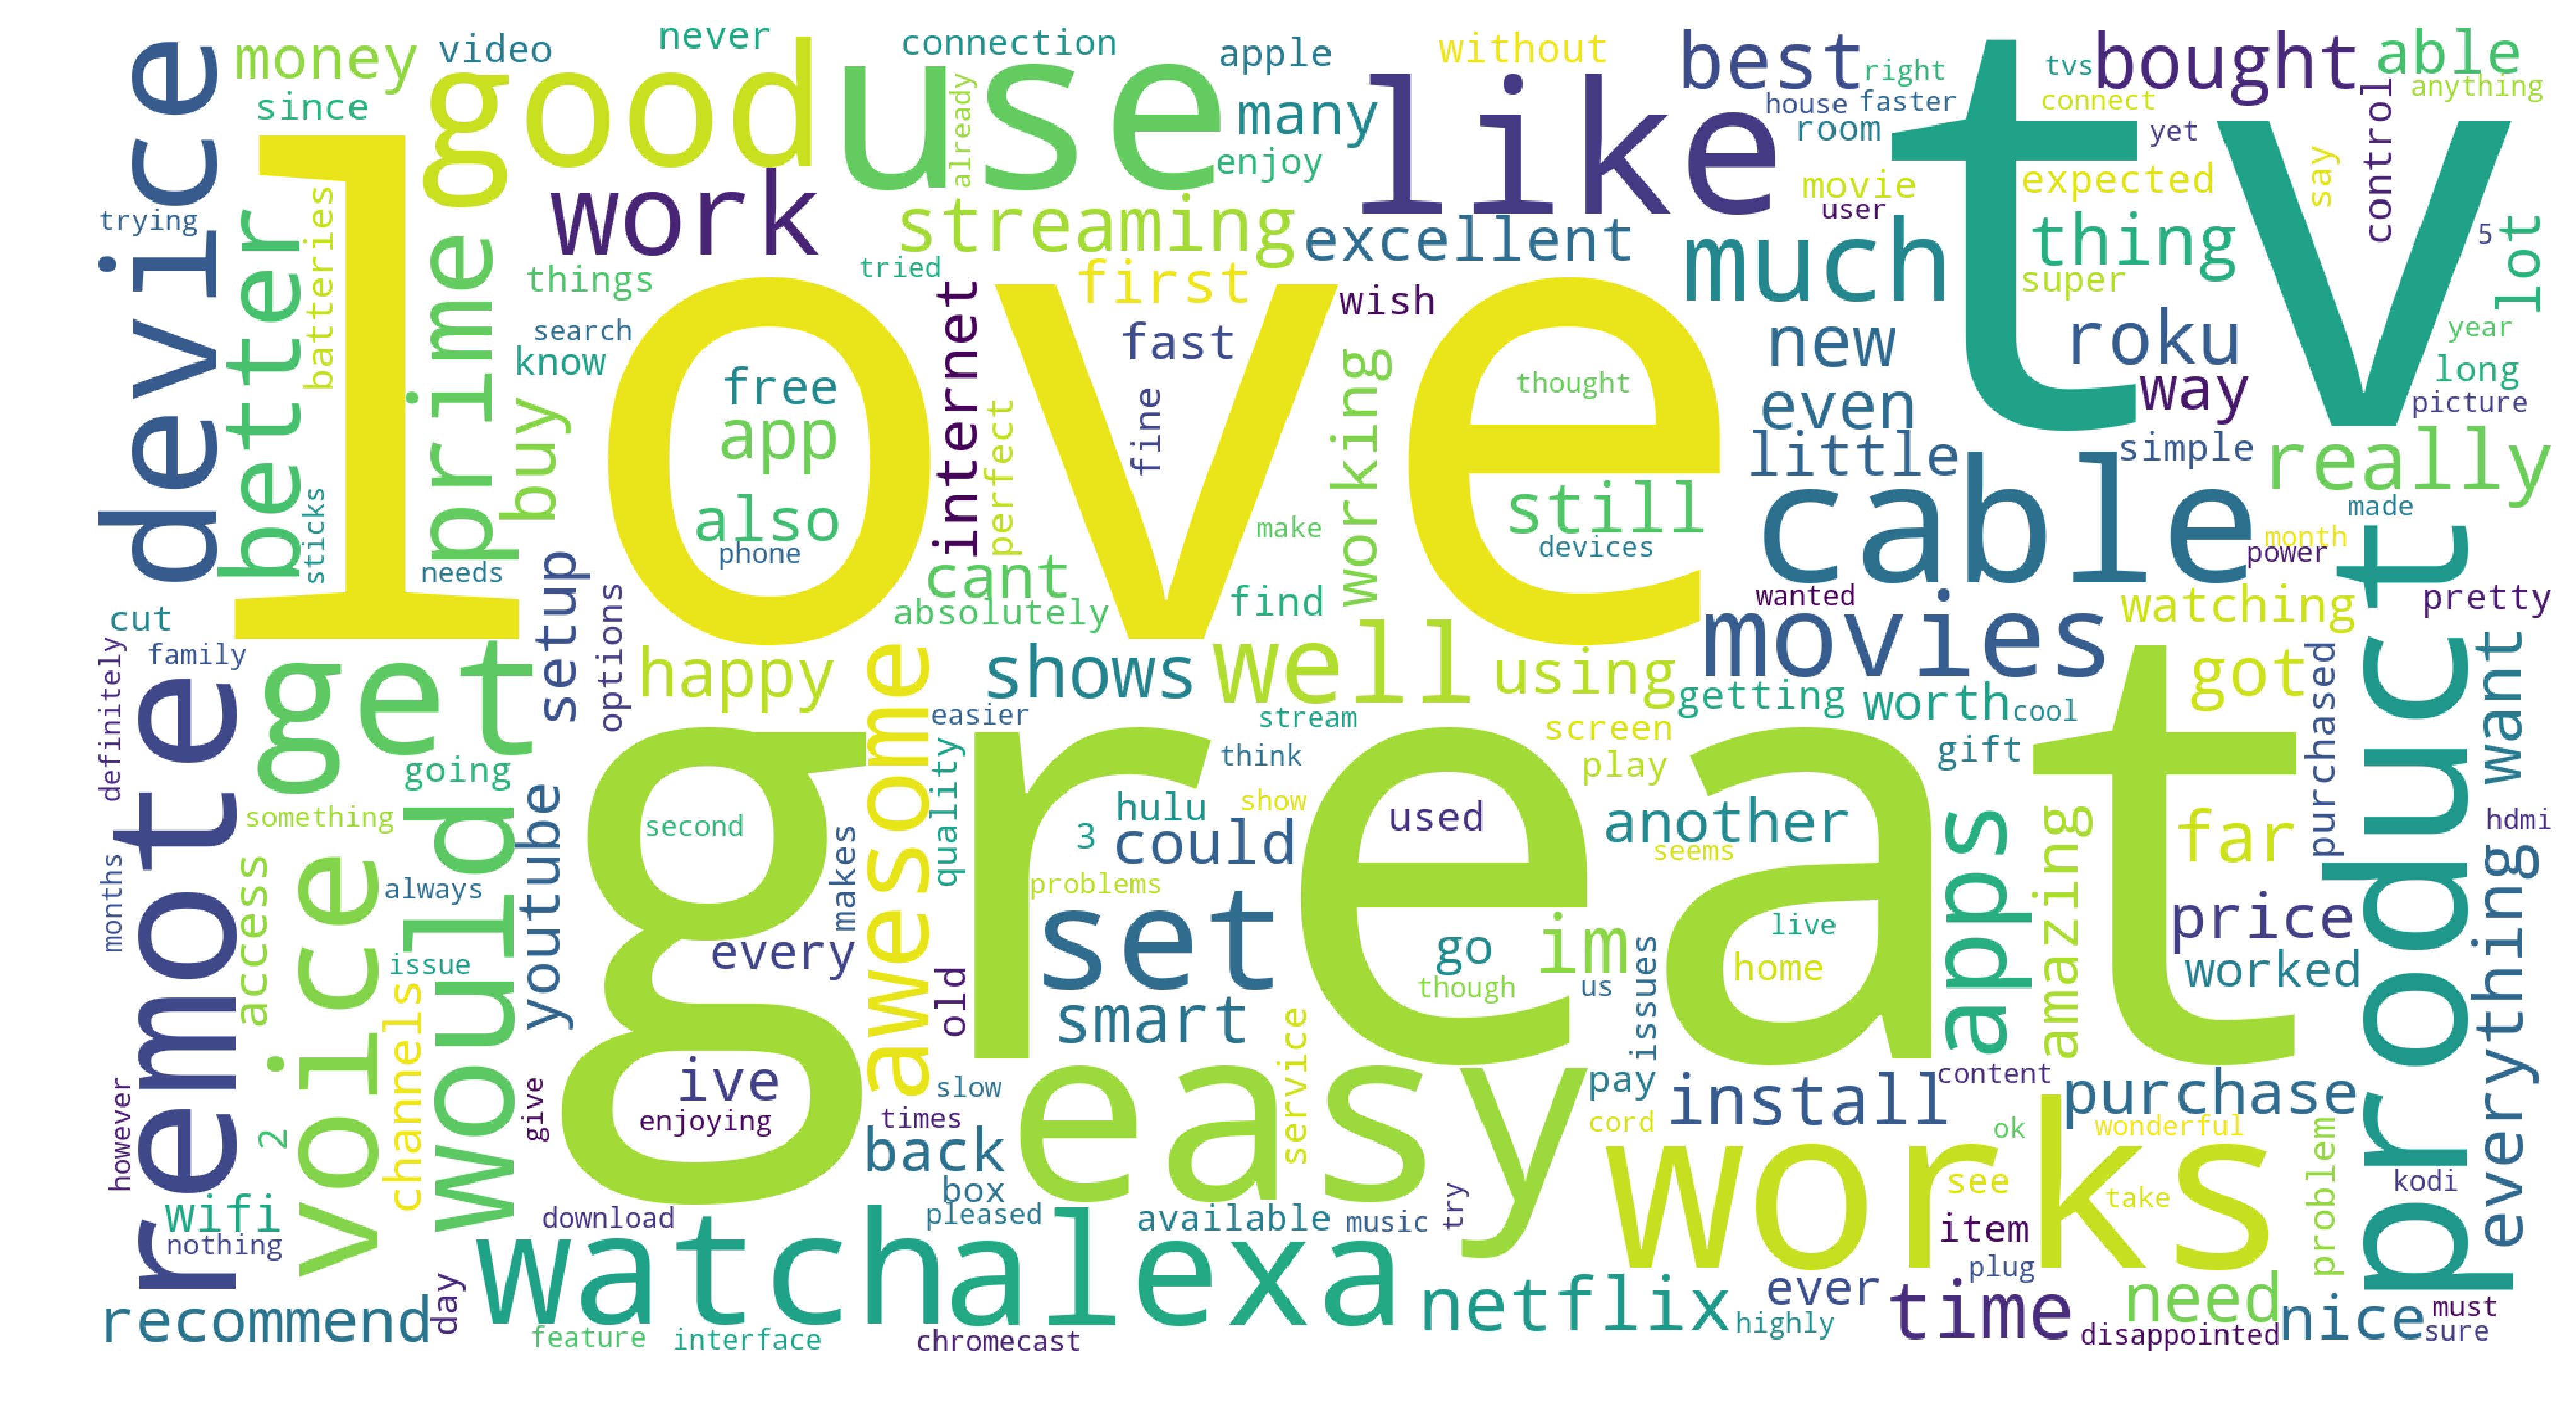

In [17]:
# Set figure size and dpi
plt.figure(figsize=(19, 10), dpi=280)

# Create wordcloud for reviewsm word tokens in df
wordcloud = WordCloud(width=1920, height=1040, background_color='white').generate_from_frequencies(word_count)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [18]:
# Set figure size and dpi
plt.figure(figsize=(19, 10), dpi=280)

# Create wordcloud for reviewsm word tokens in df1
wordcloud = WordCloud(width=1920, height=1040, background_color='white').generate_from_frequencies(word_count_1)
plt.imshow(wordcloud)
plt.title('One Star', fontdict={'fontsize':60, 'fontweight':'bold'})
plt.axis("off")
plt.show()

In [19]:
# Set figure size and dpi
plt.figure(figsize=(19, 10), dpi=280)

# Create wordcloud for reviewsm word tokens in df2
wordcloud = WordCloud(width=1920, height=1040, background_color='white').generate_from_frequencies(word_count_2)
plt.imshow(wordcloud)
plt.title('Two Stars', fontdict={'fontsize':60, 'fontweight':'bold'})
plt.axis("off")
plt.show()

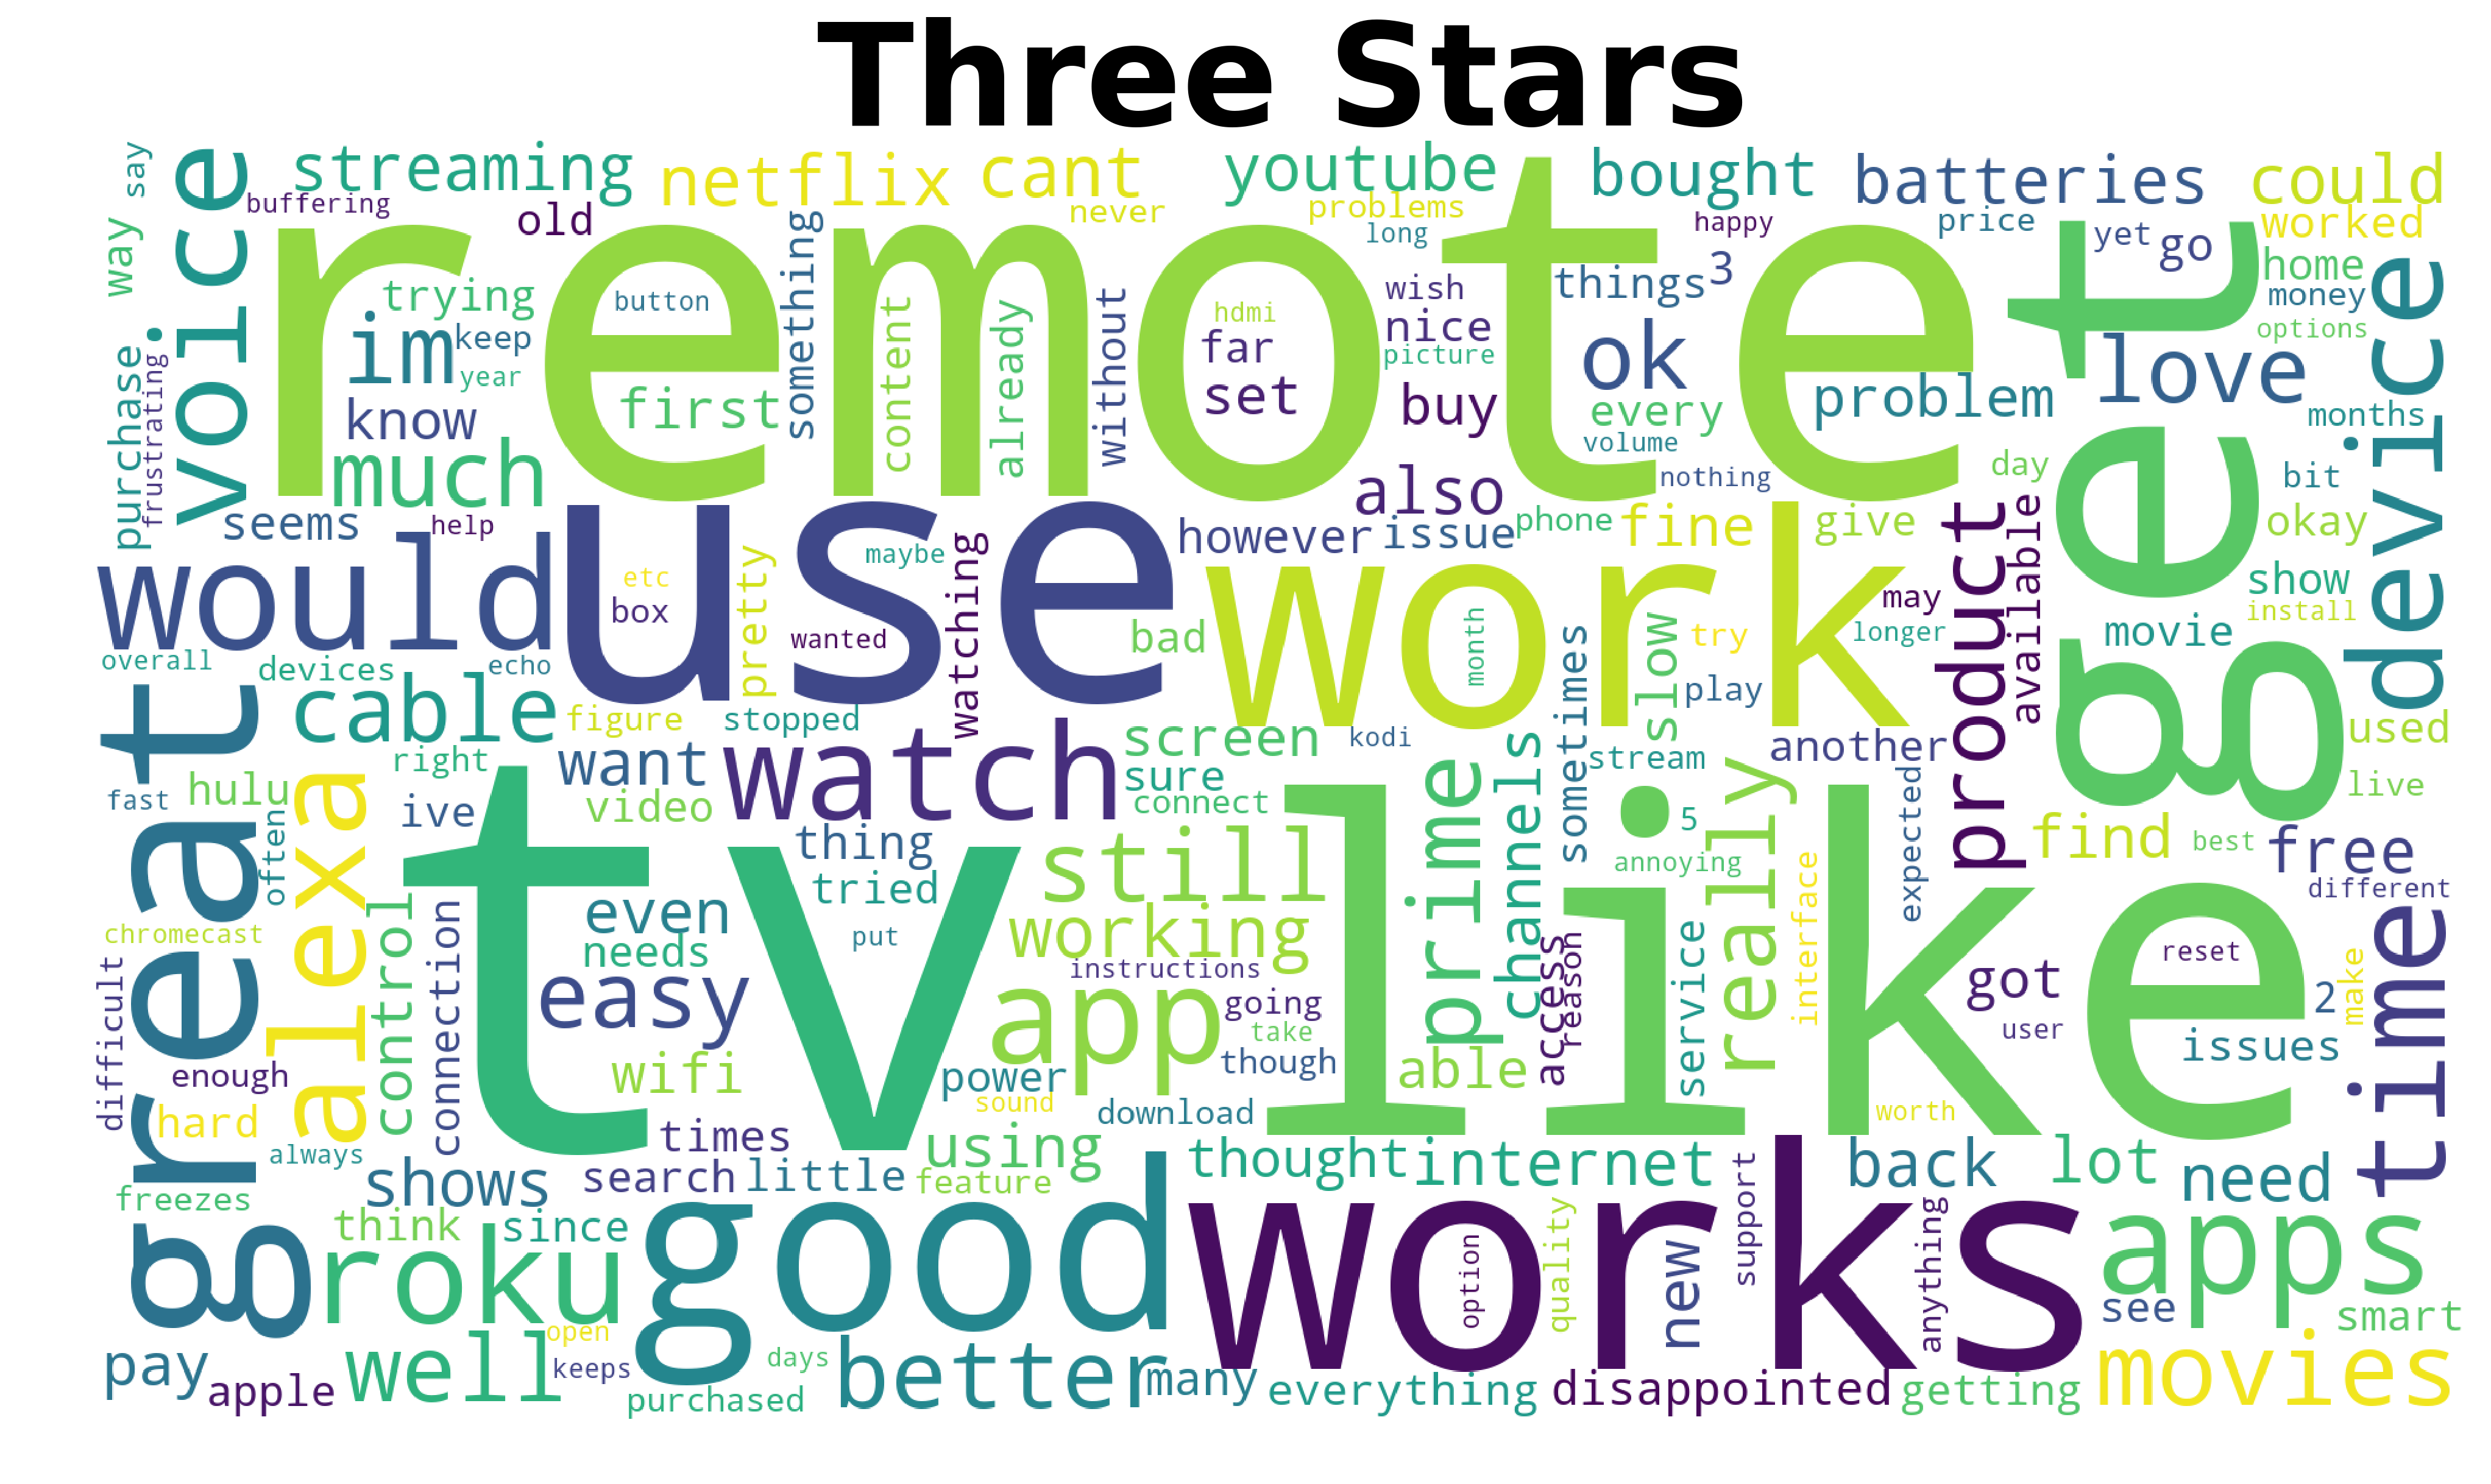

In [20]:
# Set figure size and dpi
plt.figure(figsize=(19, 10), dpi=280)

# Create wordcloud for reviewsm word tokens in df3
wordcloud = WordCloud(width=1920, height=1040, background_color='white').generate_from_frequencies(word_count_3)
plt.imshow(wordcloud)
plt.title('Three Stars', fontdict={'fontsize':60, 'fontweight':'bold'})
plt.axis("off")
plt.show()

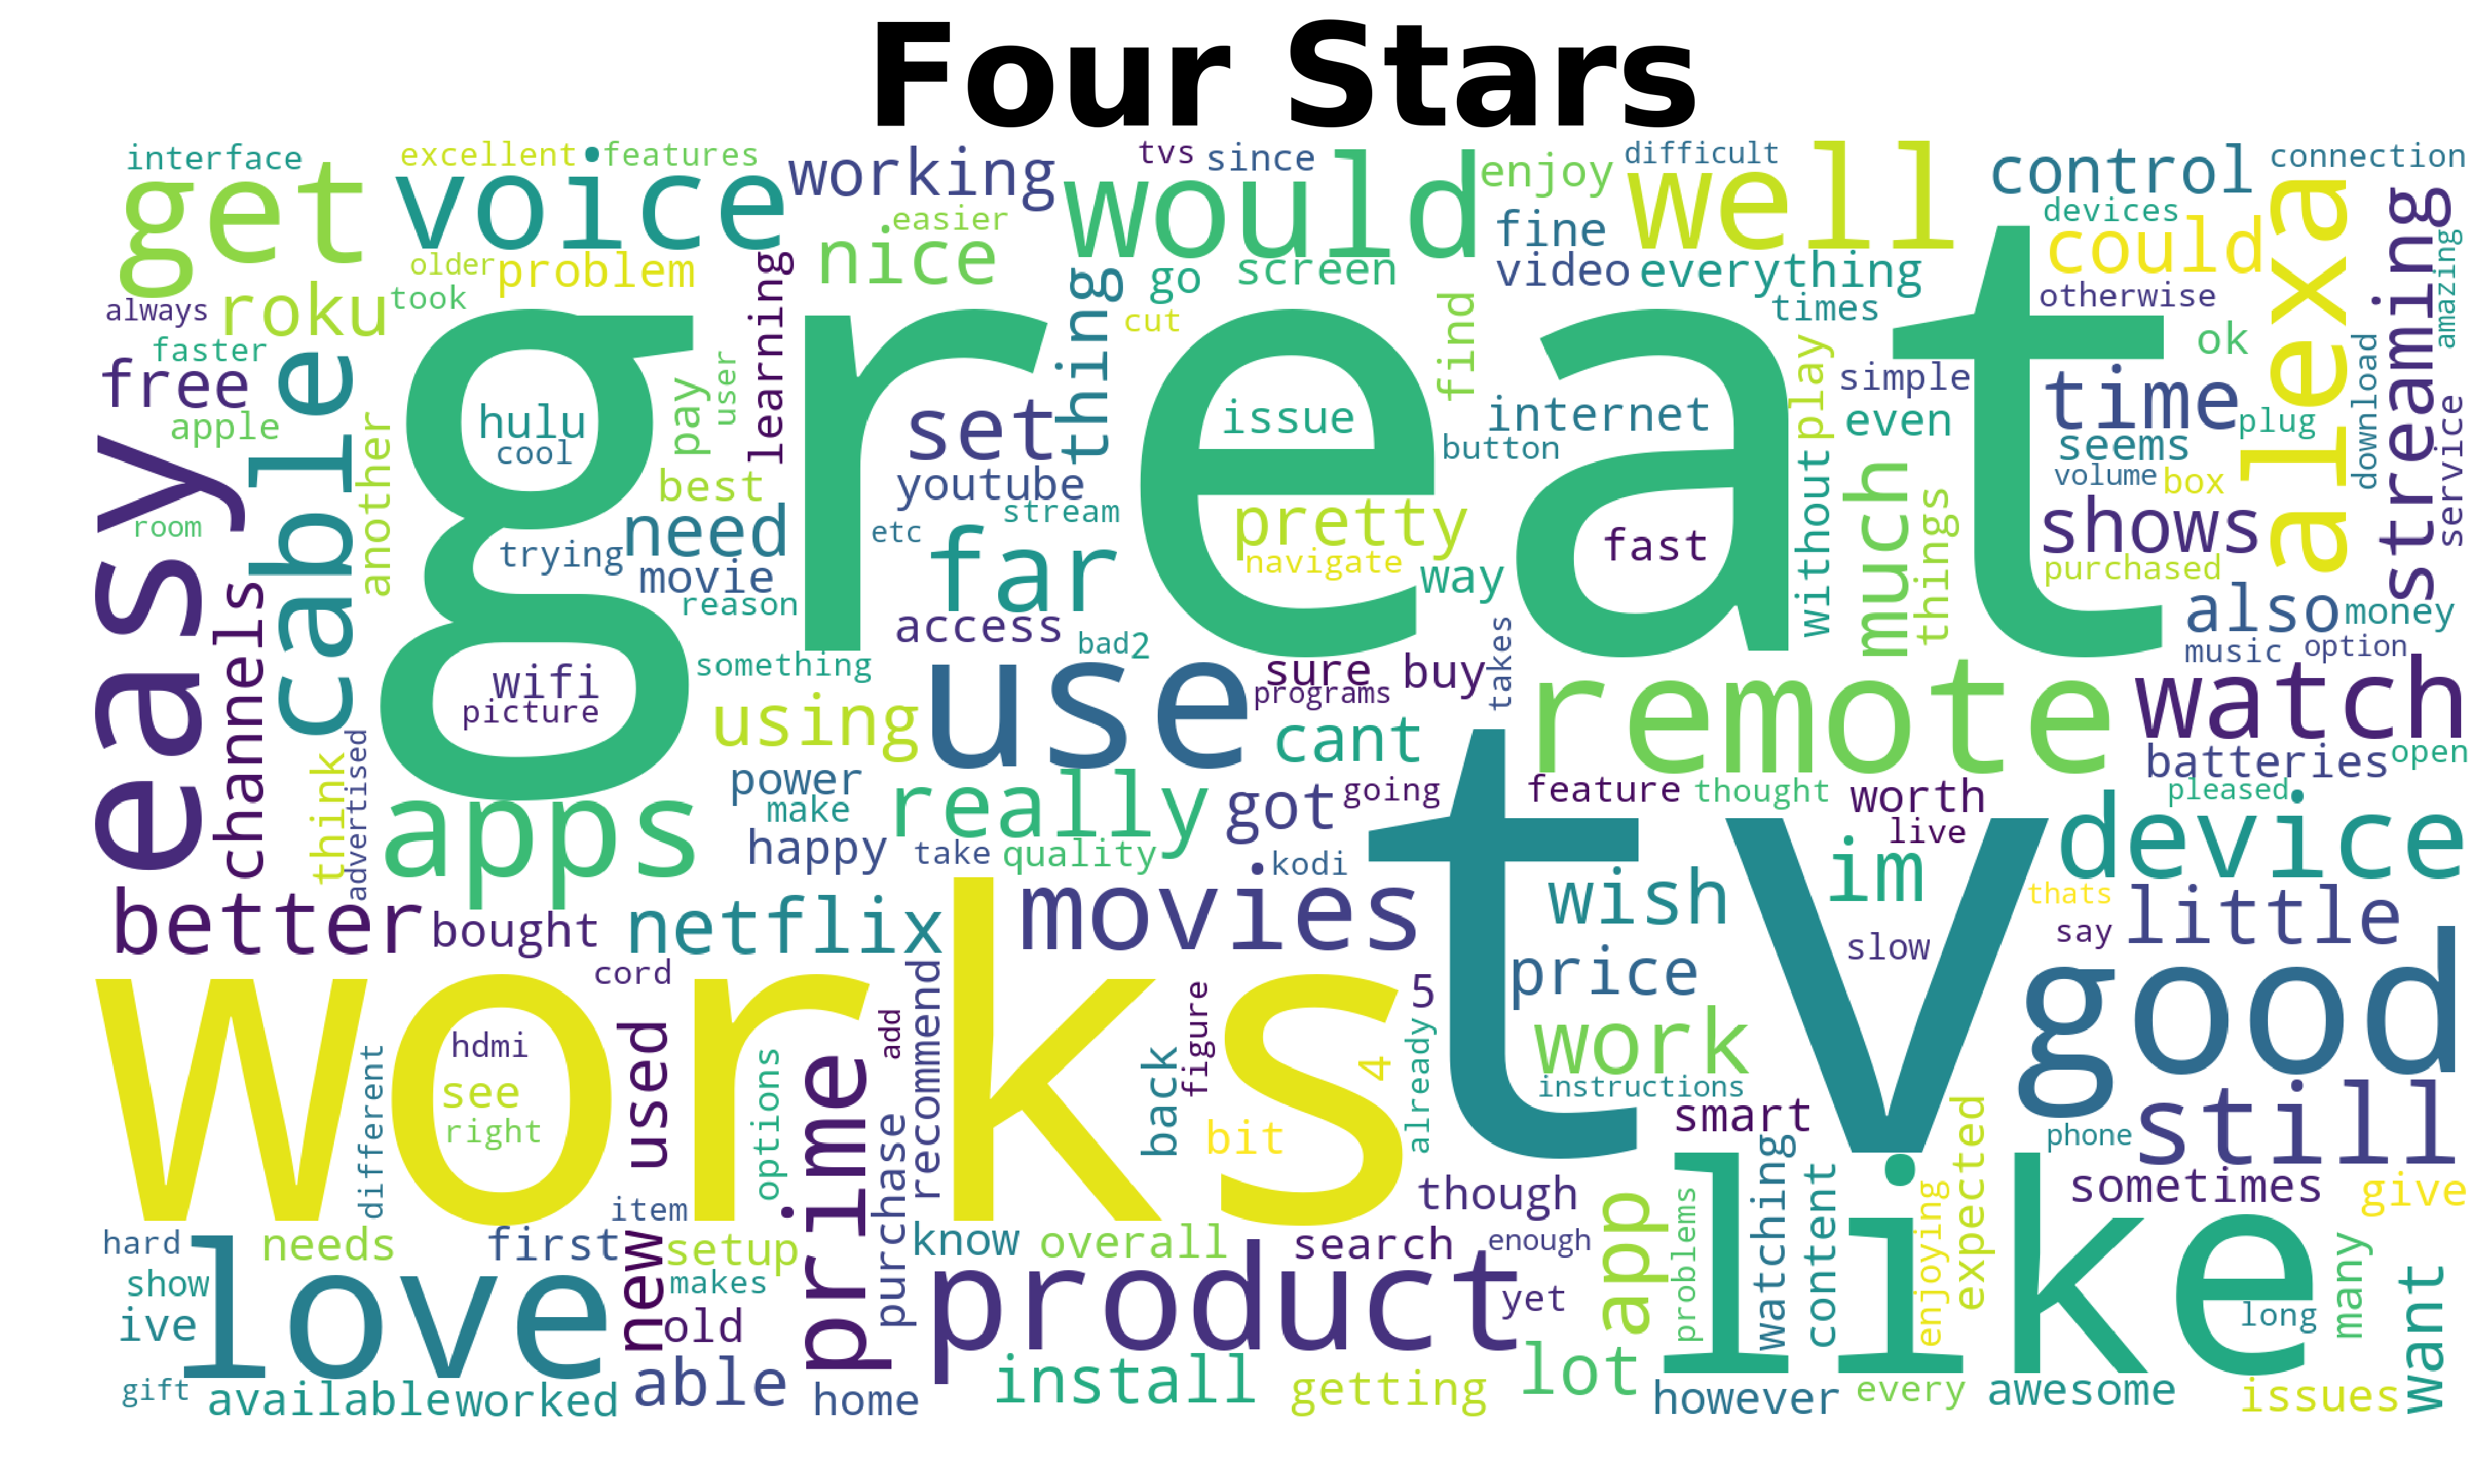

In [21]:
# Set figure size and dpi
plt.figure(figsize=(19, 10), dpi=280)

# Create wordcloud for reviewsm word tokens in df4
wordcloud = WordCloud(width=1920, height=1040, background_color='white').generate_from_frequencies(word_count_4)
plt.imshow(wordcloud)
plt.title('Four Stars', fontdict={'fontsize':60, 'fontweight':'bold'})
plt.axis("off")
plt.show()

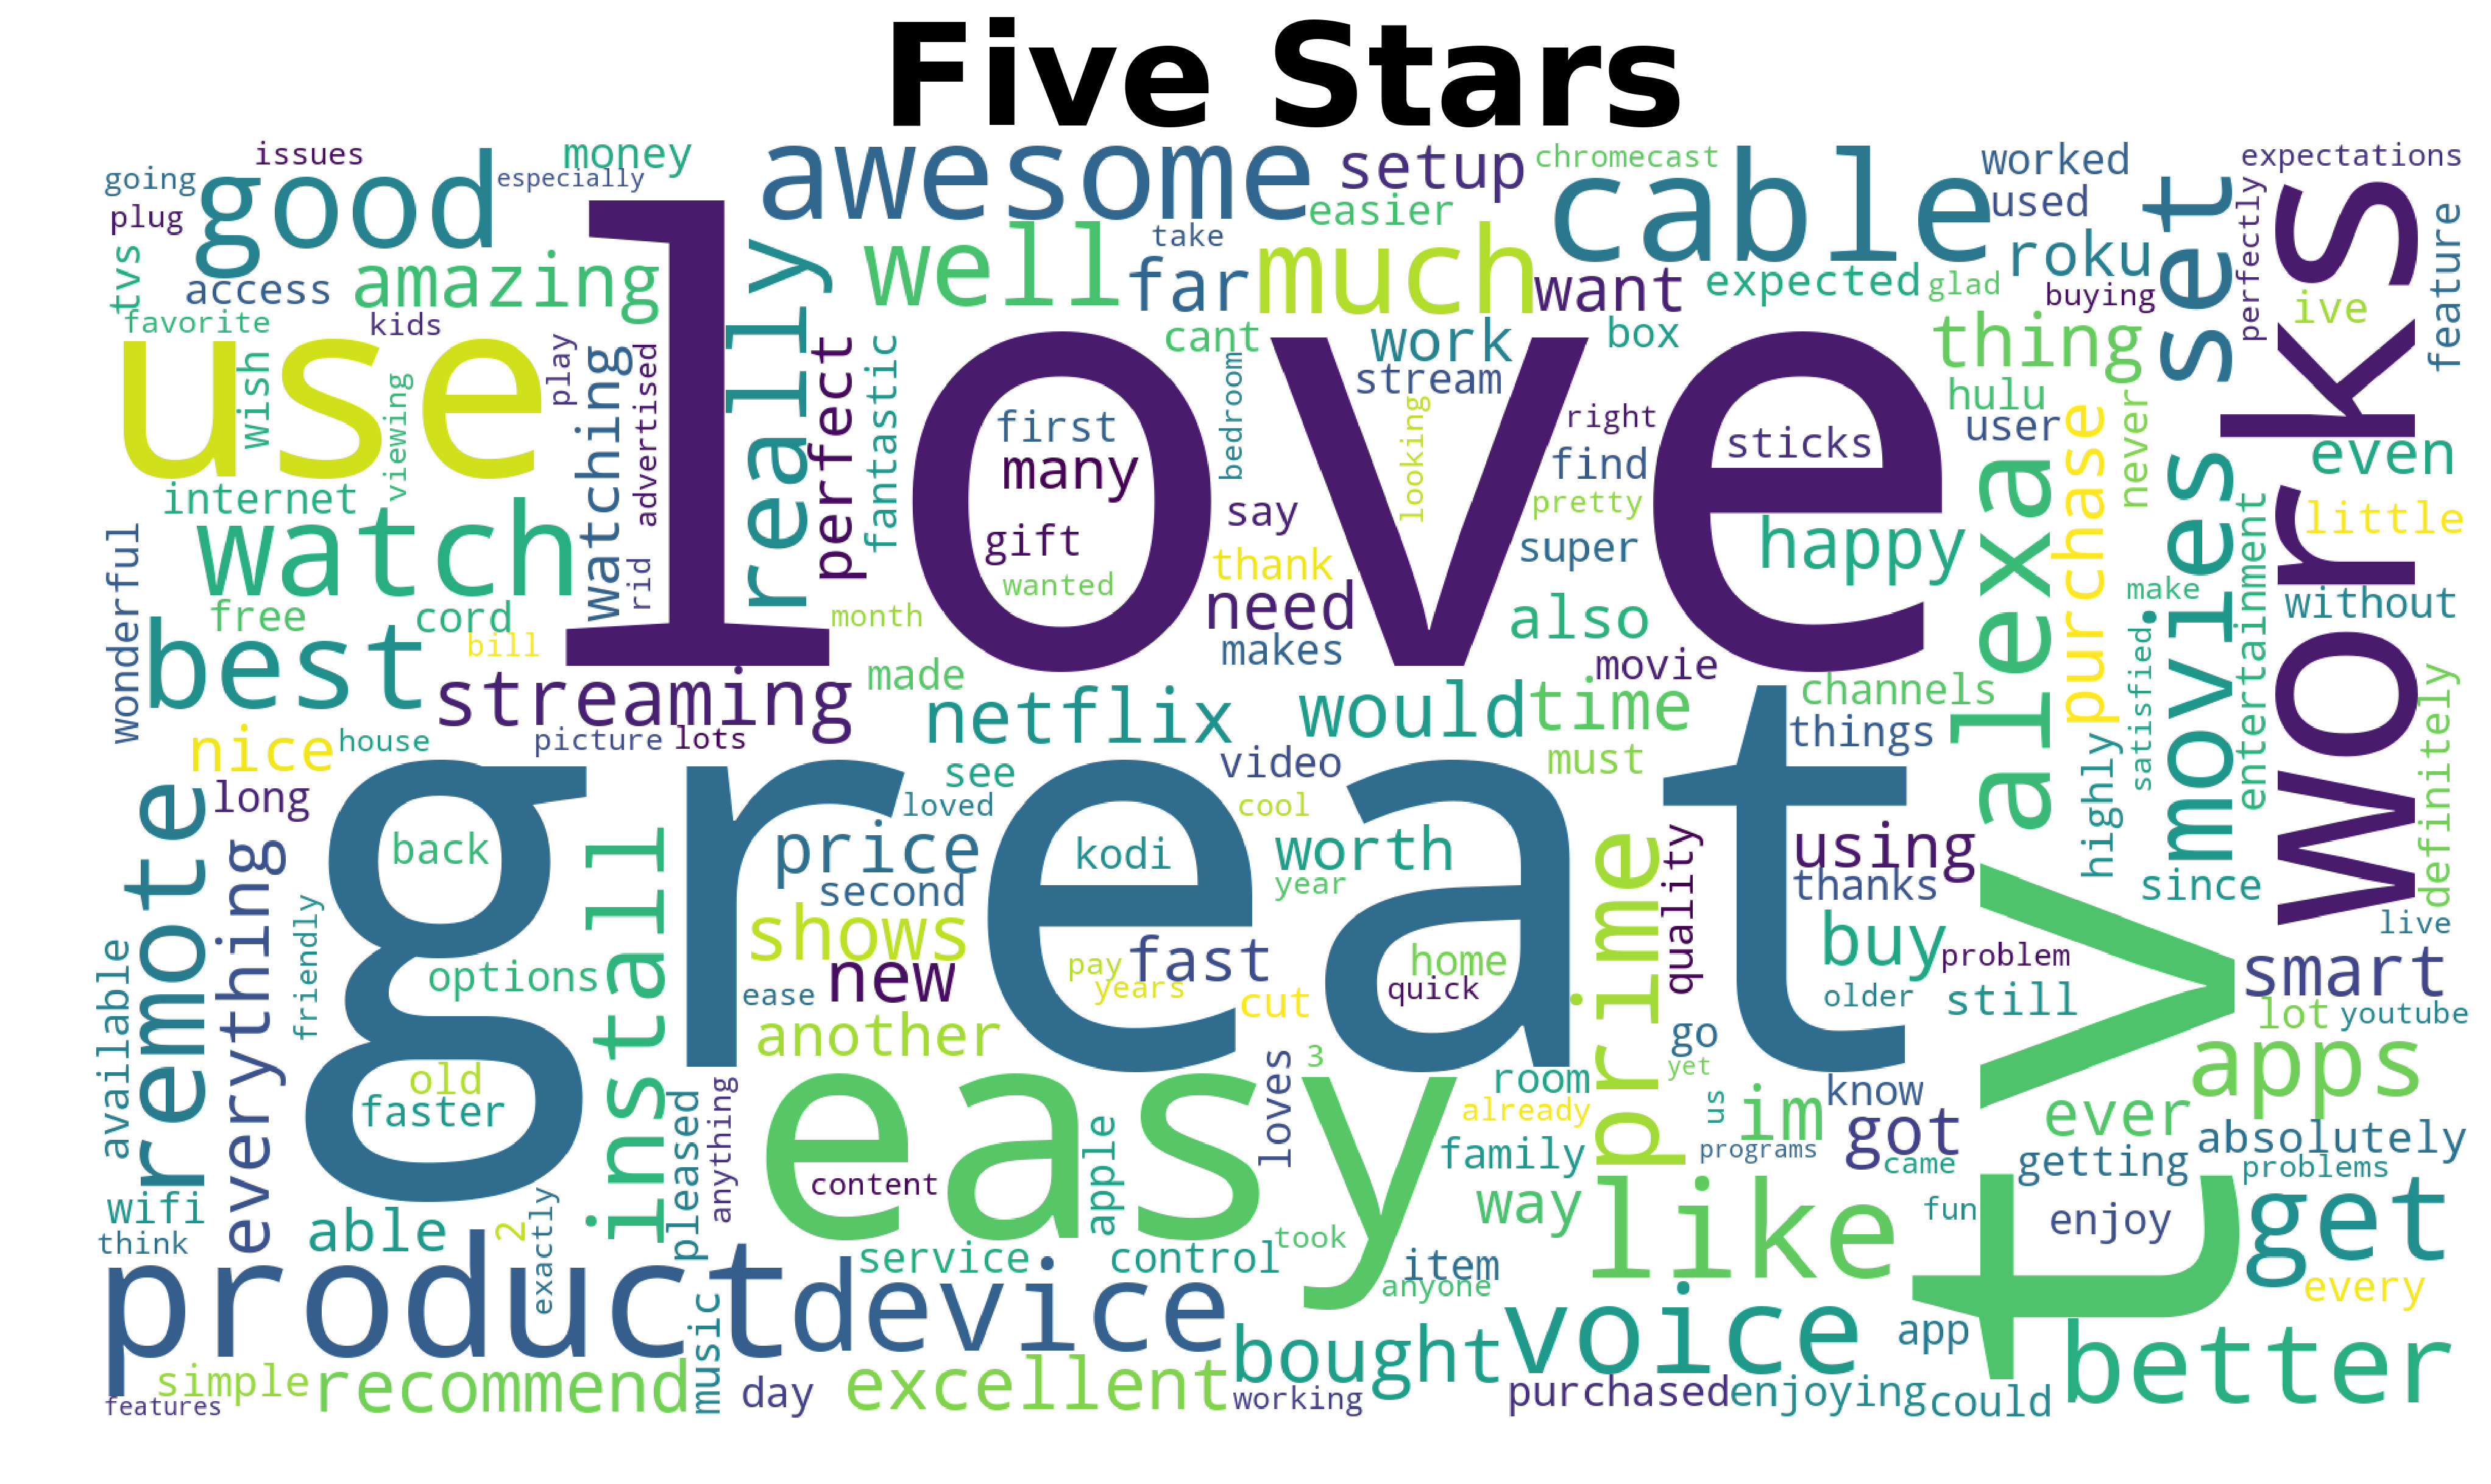

In [22]:
# Set figure size and dpi
plt.figure(figsize=(19, 10), dpi=280)

# Create wordcloud for reviewsm word tokens in df5
wordcloud = WordCloud(width=1920, height=1040, background_color='white').generate_from_frequencies(word_count_5)
plt.imshow(wordcloud)
plt.title('Five Stars', fontdict={'fontsize':60, 'fontweight':'bold'})
plt.axis("off")
plt.show()

In [23]:
# Create df with reviews that have ratings 1-3 and that contain the word "remote"
df_remote = df[((df['rating'] == 1) | (df['rating'] == 2) | (df['rating'] == 3)) & (df['all_text'].str.contains('remote'))]

# Create counter object for df_remote
remote_1_3_stars = Counter()
df_remote['word_tokens'].apply(remote_1_3_stars.update)

print()

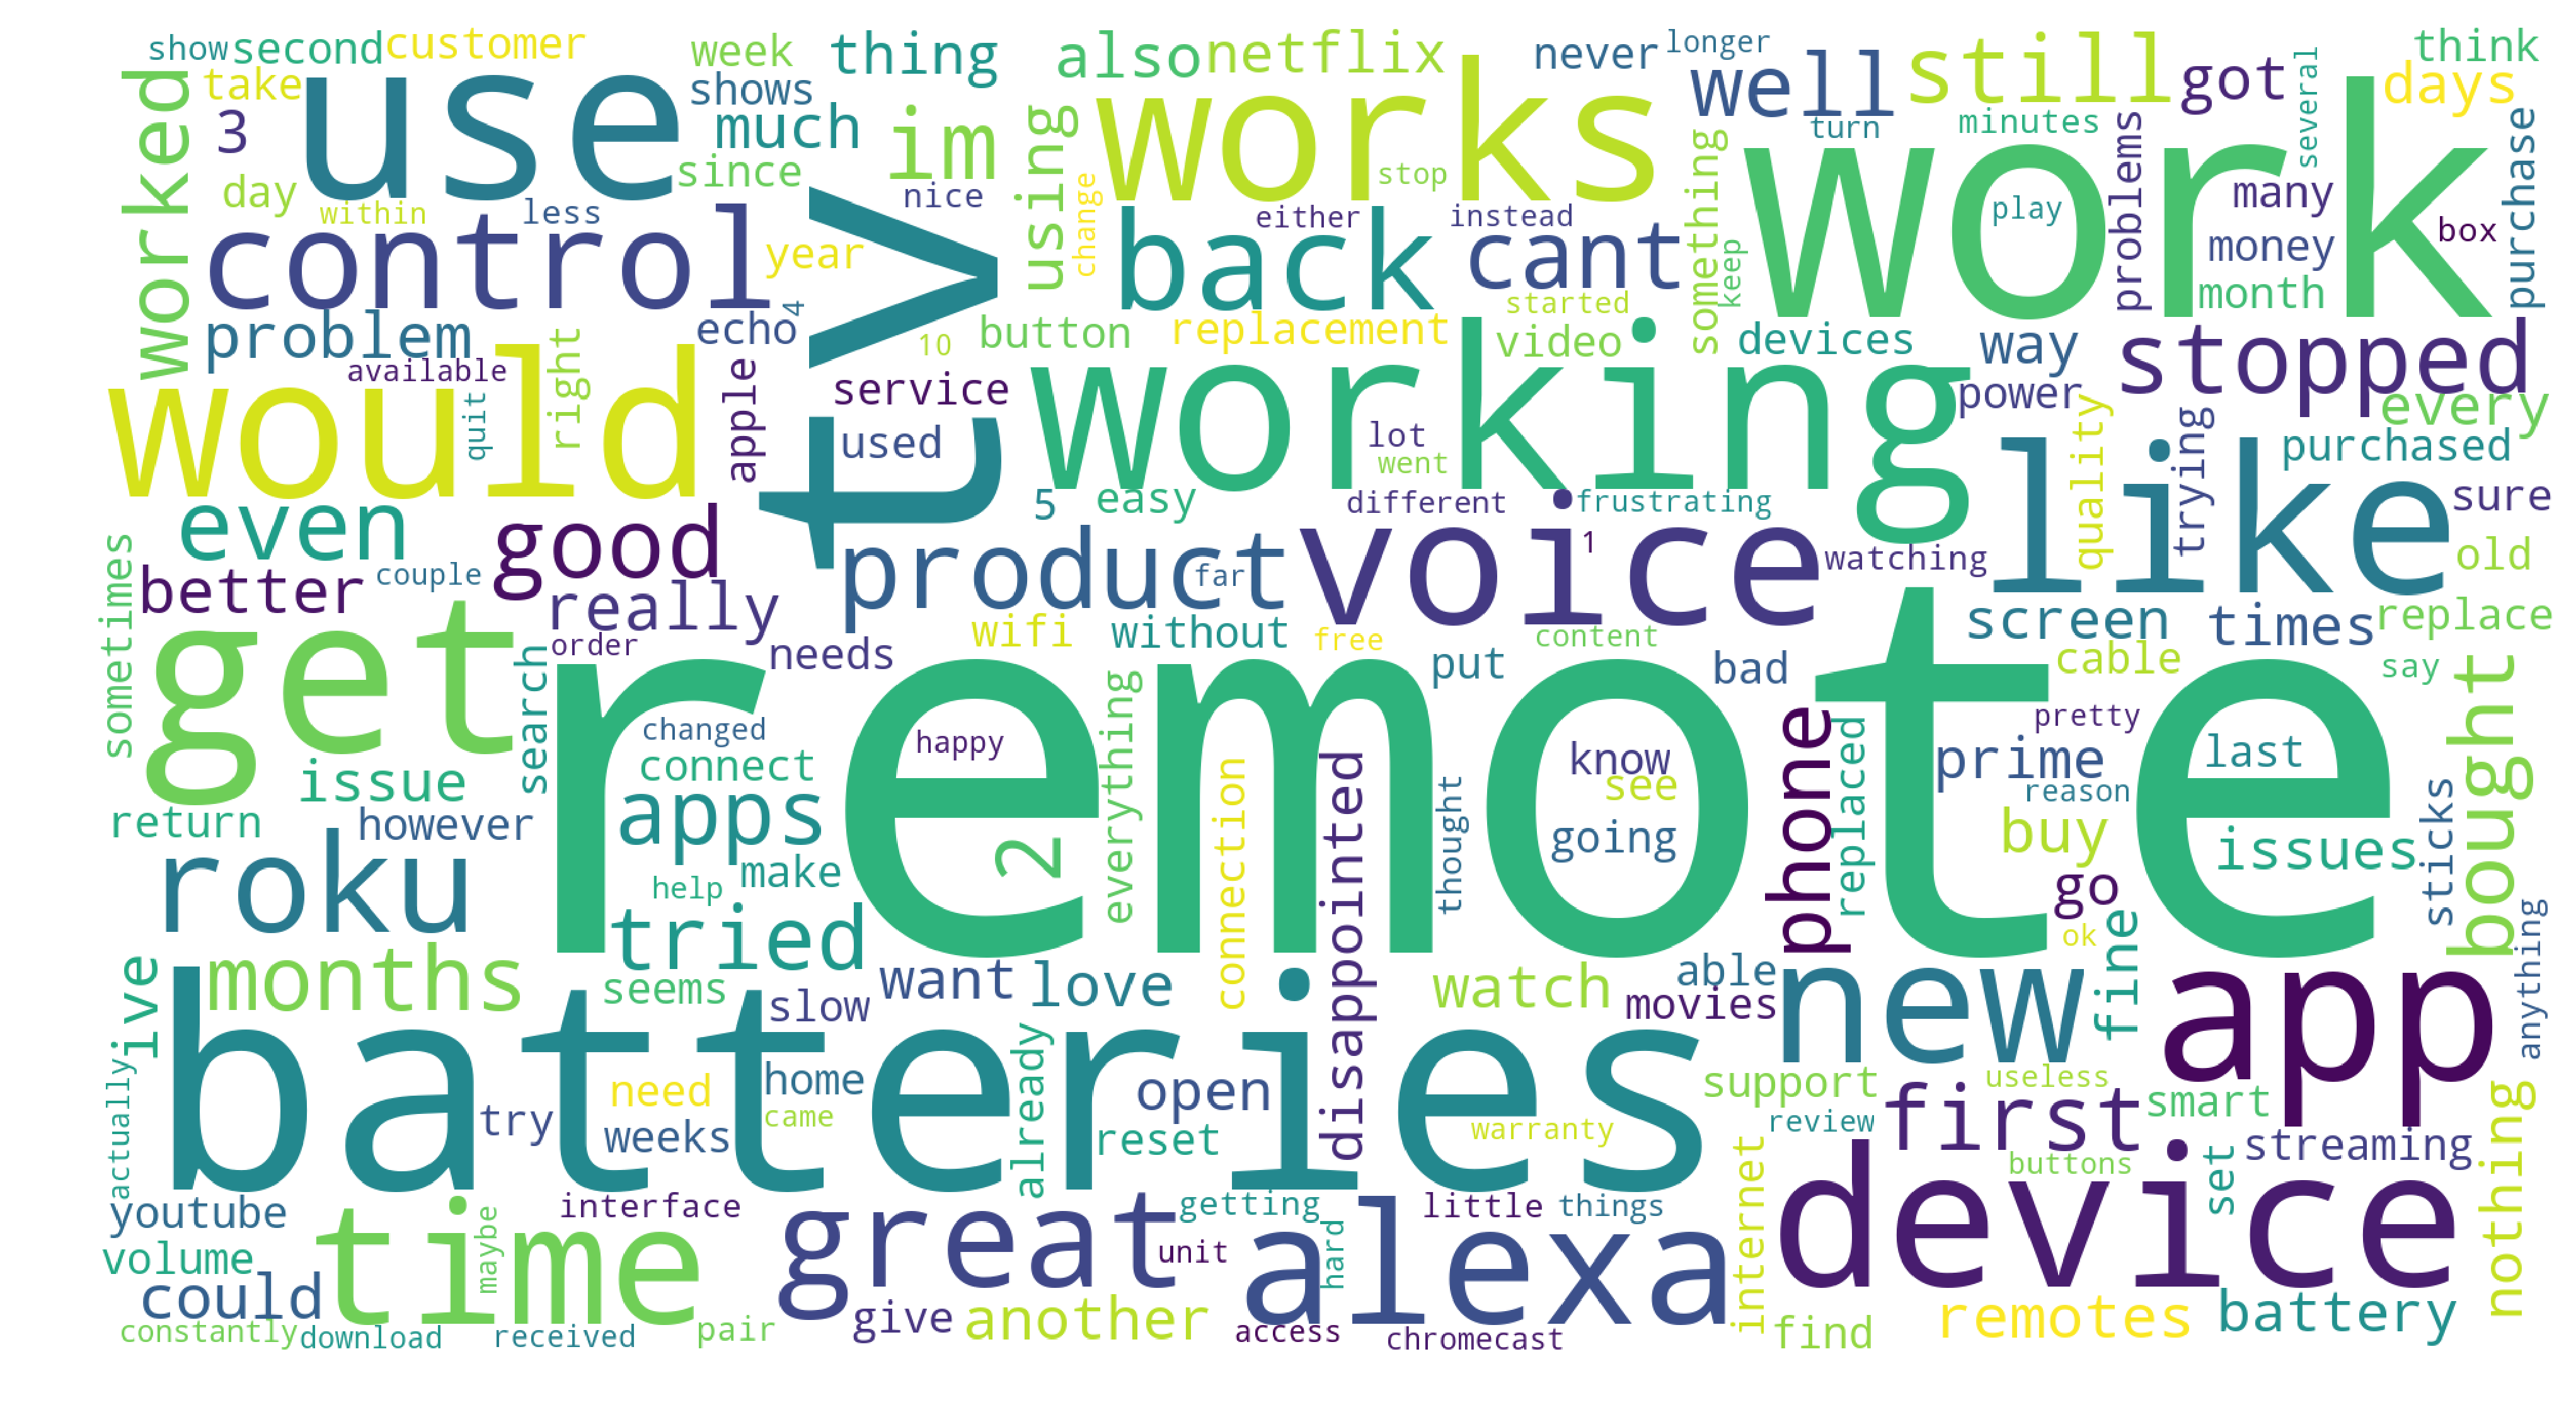

In [24]:
# Set figure size and dpi
plt.figure(figsize=(19, 10), dpi=280)

# Create wordcloud for reviewsm word tokens in df_remote
wordcloud = WordCloud(width=1920, height=1040, background_color='white').generate_from_frequencies(remote_1_3_stars)
plt.imshow(wordcloud)
# plt.title('1-3 Stars That Contain The Word Remote', fontdict={'fontsize':60, 'fontweight':'bold'})
plt.axis("off")
plt.show()

In [25]:
ratings = (1,2,3,4,5)
key_word = []
for i in ratings:
    row = []
    key_word_count = len(df[(df['rating'] == i) & (df['all_text'].str.contains('remote'))])
    rating_count = len(df[df['rating']== i])
    row.append(i)
    row.append(round((key_word_count/rating_count)*100,2))
    row.append(round(key_word_count/len(df)*100,2))
    key_word.append(row)
dfr = pd.DataFrame(key_word, columns=['rating','percent_remote', 'percent_of_total'])
dfr

rating  percent_remote  percent_of_total
0       1           14.80              0.97
1       2           17.65              0.59
2       3           15.50              0.80
3       4            9.33              1.12
4       5            3.93              2.87

In [26]:
sns.set_context("talk", font_scale=1)
sns.set_style('whitegrid')
sns.set_palette('RdYlGn')

sns.barplot(x=dfr['rating'], y=dfr['percent_remote'])
plt.xlabel('Stars')
plt.ylabel('Percent')
plt.title('Percent of Reviews That Mention Remote \n Out of Each Star Rating')
plt.show()
sns.barplot(x=dfr['rating'], y=dfr['percent_of_total'])
plt.xlabel('Stars')
plt.ylabel('Percent')
plt.title('Percent of Reviews That Mention Remote \n Out of Total')

plt.show()